# Import Required Libraries

In [1]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

## Import Image

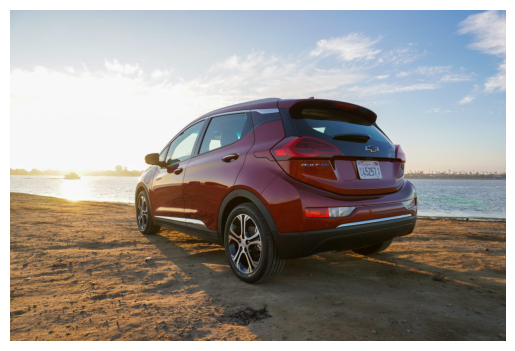

In [2]:
cars = cv2.imread("images/car.jpg")

plt.imshow(cars[:,:,::-1]);
plt.axis("off");

# Load Models

In [3]:
model_v8   = YOLO('models/yolov8n.pt')
east_model = cv2.dnn.readNet("models/frozen_east_text_detection.pb")

In [4]:
### Layer names that we are interested in from EAST model

layernames = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]

In [5]:
def plot_img(img):
    plt.axis('off');
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
    plt.show();

## Blur NumberPlates

In [14]:
class BlurImage:
    def __init__(self,image,yolo_model,east_model):
        self.image = image
        self.yolo_model = yolo_model
        self.east_model = east_model
        
    def get_bounding_boxes(self):
        ### Predict Classes from image
        predict_image = self.yolo_model(self.image)
        
        print(self.image.shape)
        
        ### Filter only cars
        predict_image[0].boxes.data = torch.stack([box for box in predict_image[0].boxes.data if (int(box[5]) == 2) and (box[4] > 0.5)])
        boxes = predict_image[0].boxes.data
        
        ### Plot
        res_plot = predict_image[0].plot()
        plot_img(res_plot)
        
        roi = []
        for index in range(len(boxes)):
            roi =  self.image[int(boxes[index][1]) : int(boxes[index][3]), int(boxes[index][0]) : int(boxes[index][2])] 
            text_extracted_roi,roi_boxes = self.text_detector(roi)
            print(len(boxes))
            roi = text_extracted_roi[roi_boxes[0][1]:roi_boxes[0][3], roi_boxes[0][0]:roi_boxes[0][2]]

            # ### blur image 
            blur_image = cv2.GaussianBlur(roi,(51,51),0)

            text_extracted_roi[roi_boxes[0][1]:roi_boxes[0][3], roi_boxes[0][0]:roi_boxes[0][2]] = blur_image

            # plt.imshow(labeled[:,:,::-1]);
            # plt.axis("off");
            print(roi_boxes)
        plot_img(text_extracted_roi)
            
    def text_detector(self,image):
        #hasFrame, image = cap.read()
        orig = image
        (H, W) = image.shape[:2]

        (newW, newH) = (640, 320)
        rW = W / float(newW)
        rH = H / float(newH)

        image = cv2.resize(image, (newW, newH))
        (H, W) = image.shape[:2]

        layerNames = [
            "feature_fusion/Conv_7/Sigmoid",
            "feature_fusion/concat_3"]


        blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
            (123.68, 116.78, 103.94), swapRB=True, crop=False)

        self.east_model.setInput(blob)
        (scores, geometry) = self.east_model.forward(layerNames)

        (numRows, numCols) = scores.shape[2:4]
        rects = []
        confidences = []

        for y in range(0, numRows):

            scoresData = scores[0, 0, y]
            xData0 = geometry[0, 0, y]
            xData1 = geometry[0, 1, y]
            xData2 = geometry[0, 2, y]
            xData3 = geometry[0, 3, y]
            anglesData = geometry[0, 4, y]

            # loop over the number of columns
            for x in range(0, numCols):
                # if our score does not have sufficient probability, ignore it
                if scoresData[x] < 0.5:
                    continue

                # compute the offset factor as our resulting feature maps will
                # be 4x smaller than the input image
                (offsetX, offsetY) = (x * 4.0, y * 4.0)

                # extract the rotation angle for the prediction and then
                # compute the sin and cosine
                angle = anglesData[x]
                cos = np.cos(angle)
                sin = np.sin(angle)

                # use the geometry volume to derive the width and height of
                # the bounding box
                h = xData0[x] + xData2[x]
                w = xData1[x] + xData3[x]

                # compute both the starting and ending (x, y)-coordinates for
                # the text prediction bounding box
                endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
                endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
                startX = int(endX - w)
                startY = int(endY - h)

                # add the bounding box coordinates and probability score to
                # our respective lists
                rects.append((startX, startY, endX, endY))
                confidences.append(scoresData[x])

        boxes = non_max_suppression(np.array(rects), probs=confidences)
        for (startX, startY, endX, endY) in boxes:

            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            # draw the bounding box on the image
            cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        return orig,boxes
                
        
            


0: 448x640 1 car, 1 boat, 179.0ms
Speed: 6.0ms preprocess, 179.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


(1282, 1920, 3)


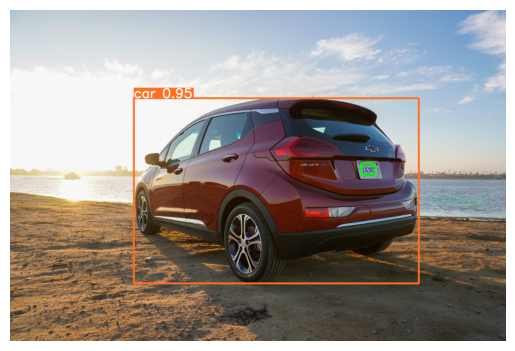

1
[[509 113 543 131]]


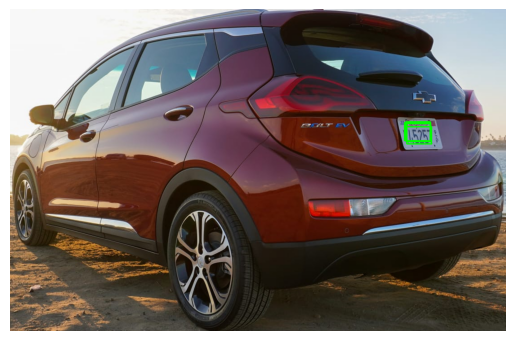

In [15]:
BlurImage(cars, model_v8,east_model ).get_bounding_boxes()

In [33]:
cars.shape

(414, 621, 3)